In [1]:
# The ProteinUnfolding2D module depends on modules xlrd and lmfit
import sys
sys.path.append('../')

import ProteinUnfolding2D
import numpy as np

# Read any number of NanoDSF Excel files into a parser, see help(ProteinUnfolding2D)
nanodsf_data = ProteinUnfolding2D.NanoDsfParser("data/20191202_ACBP_15C_95C_processed.xlsx")
n_samples = nanodsf_data.info()

File  0 with 16 samples, 2 curves (['I330', 'I350']) and 3181 temperature points : 'data/20191202_ACBP_15C_95C_processed.xlsx'


Number of samples (capilaries): 15
Curves: ['I330', 'I350']
Temperature range 15.00 - 95.00 deg C
Denaturent serie: [3.01, 2.81, 2.6, 2.41, 2.21, 2.0, 1.81, 1.6, 1.4, 1.21, 1.0, 0.8, 0.6, 0.4, 0.19]


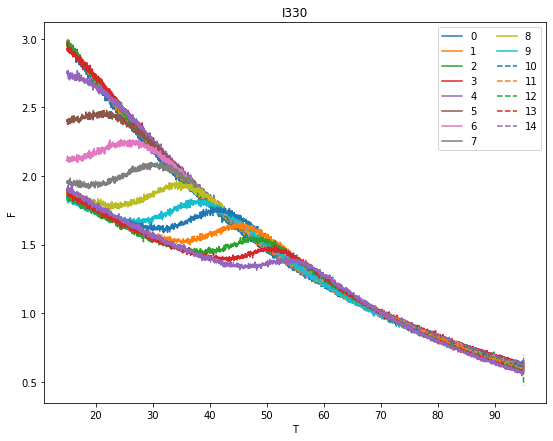

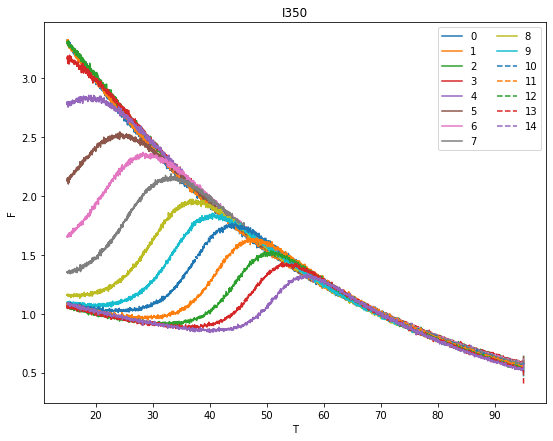

In [2]:
# Select a slice of data to fit
data2fit = nanodsf_data.get(range(0,15), temp_min=15, curve_labels=['I330','I350'])

# Additional functions for data slicing
# del data2fit[1]
# data2fit[3]['I330'][:] = np.nan
# data2fit.extend(nanodsf_data.get(range(1,3), temp_min=16, temp_max=85, curve_labels=['I330']))

# Normalization
data2fit = data2fit.norm2temp(70, norm2one=True)

# Dump info on selected data
print("Number of samples (capilaries): %d" % len(data2fit))
print("Curves: %s" % (str(data2fit.get_curve_labels())))
(temp_min, temp_max) = data2fit.get_temp_range()
print("Temperature range %.2f - %.2f deg C" % (temp_min,temp_max))
denat = [d['DENAT'] for d in data2fit]
print("Denaturent serie: %s" % (str(denat)))

# Look at selected data before fitting
%matplotlib inline
import matplotlib.pyplot as plt
from cycler import cycler
from matplotlib.colors import TABLEAU_COLORS as tab_col

# Temperature plot
plt.rc('axes', prop_cycle=(cycler('color',  [*tab_col]*3)+
                           cycler('linestyle', ['-']*10+['--']*10+[':']*10)))
for label in data2fit.get_curve_labels():
    fig, ax = plt.subplots(figsize=(9, 7))
    for di in range(len(data2fit)):
        if label in data2fit[di].keys():
            ax.plot(data2fit[di]['T'], data2fit[di][label], label=str(di))
    legend = ax.legend(loc='upper right', ncol=len(data2fit)//10+1)
    plt.xlabel('T'); plt.ylabel('F'); plt.title(label); plt.show()

In [3]:
from ipywidgets import interact,IntSlider

# Data y-range
Imin = np.nan; Imax = np.nan
for label in data2fit.get_curve_labels():
    Imin = np.nanmin(np.concatenate([np.array([Imin])]+[(d[label] if label in d.keys() else []) for d in data2fit]))
    Imax = np.nanmax(np.concatenate([np.array([Imax])]+[(d[label] if label in d.keys() else []) for d in data2fit]))
I10pct = (Imax-Imin)/10.0
    
# Plot denaturant curve(s) at selected temperature
def f(T):
    fig, ax = plt.subplots(figsize=(7, 5))
    for label in data2fit.get_curve_labels():
        curve = [(d[label][np.argmin(np.abs(d['T']-T))] if label in d.keys() else np.NaN) for d in data2fit]
        ax.plot(denat, curve, 'o-', label=label)
    plt.ylim(Imin-I10pct,Imax+I10pct); plt.xlabel('Denaturant'); plt.ylabel('Intensity')
    legend = ax.legend(loc='upper left')
    plt.show()

i = interact(f, T=IntSlider(min=temp_min, max=temp_max, step=1, value=temp_min, continuous_update=False))

interactive(children=(IntSlider(value=15, continuous_update=False, description='T', max=95, min=15), Output())…

In [4]:
# Thermodynamic function of fit
R = 8.314e-3   # Gas constant in kJ/K/mol
#R = 1.985e-3  # Gas constant in kcal/K/mol
K0 = -273.15   # Zero Kelvin in Celcius 

def unfold2d_I330_I350(temp_target, temp, denat, label,
                       a_F_I330=1.0, b_F_D_I330=0.0, b_F_T_I330=0.0,
                       a_U_I330=1.0, b_U_D_I330=0.0, b_U_T_I330=0.0, b_U_T2_I330=0.0,
                       a_F_I350=1.0, b_F_D_I350=0.0, b_F_T_I350=0.0,
                       a_U_I350=1.0, b_U_D_I350=0.0, b_U_T_I350=0.0, b_U_T2_I350=0.0,
                       Tm=70.0, dH=300.0, dCp=2.0, m0=1.0, m1=0.0, m2=0.0):
    # NanoDsf temperatures are in Celsius, thermodynamics in Kelvin
    T_K = temp - K0
    if Tm < -100:
        print("WARNING: Very low melting temperature %.1f" % (Tm))
    Tm_K = Tm - K0
    ToTm = T_K/Tm_K
    dT = temp - temp_target
    dT2 = dT*dT
    # Free energy of unfolding, dH, dCp and m should be positive
    dG_H2O = dH*(1-ToTm) + dCp*(T_K-Tm_K-T_K*np.log(ToTm))
    mD = denat*(m0 + m1*dT + m2*dT2)
    dG_U = dG_H2O - mD
    # Conditions where the protein is very unstable is capped to avoid explosion of exp
    # I could make a log approximation to secure gradients in this region if optimization is stuck in this region
    if np.any(dG_U < -250):
        i = np.where(dG_U < -250)
        dG_U[i] = -250
        print("WARNING: Bounded %d dG values to -250" % (len(i)))
    exp_dG = np.exp( -dG_U/(R*T_K) )
    # 330nm curve_label with folded (F) and unfolded (U) base planes
    bp_F_I330 = (a_F_I330 + b_F_D_I330*denat + b_F_T_I330*dT)
    bp_U_I330 = (a_U_I330 + b_U_D_I330*denat + b_U_T_I330*dT + b_U_T2_I330*dT2)
    I330 = (bp_F_I330 + exp_dG*bp_U_I330) / (1+exp_dG)
    # 350nm curve_label with folded (N) and denatured (D) base planes
    bp_F_I350 = (a_F_I350 + b_F_D_I350*denat + b_F_T_I350*dT)
    bp_U_I350 = (a_U_I350 + b_U_D_I350*denat + b_U_T_I350*dT + b_U_T2_I350*dT2)
    I350 = (bp_F_I350 + exp_dG*bp_U_I350) / (1+exp_dG)
    # Return an array where numbers match the curve_label label
    ret = np.where(label=='I330', I330, 0.0) + np.where(label=='I350', I350, 0.0)
    return(ret)

# Calculate dG of unfolding for a given model and temperature
def calc_dG(param, temp, denat=0.0):
    p = param.valuesdict()
    T = temp - K0; Tm = p['Tm'] - K0
    dT = temp - temp_target
    dG = p['dH']*(1-T/Tm) + p['dCp']*(T-Tm-T*np.log(T/Tm)) - denat*(p['m0'] + p['m1']*dT + p['m2']*dT*dT)
    return(dG)

In [5]:
# The target temperature to calculate final dG and center m-value expansion
temp_target = 25

# Model wrapper for the function to fit, see help(Unfolding2D.Unfold2dModel)
unfold2d_model = ProteinUnfolding2D.Unfold2DModel(unfold2d_I330_I350, 
                                           independent_vars=['temp_target', 'temp', 'denat', 'label'])
# Initial parameters
param_init = unfold2d_model.make_params()

# Guess dCp and m-value based on the number of residues in the protein
Nres = 90
unfold2d_model.guess_Cp_m(Nres, R=R, params=param_init)

# Trun off the higher order m-value terms
param_init['m1'].set(0.0, vary=False)
param_init['m2'].set(0.0, vary=False)

# Guess base-plane parameters for all curves
for label in data2fit.get_curve_labels():
    unfold2d_model.guess_baseplane(data2fit, temp_target, label, params=param_init)
    # Guess the curvature of the unfolded temperature baseline
    unfold2d_model.guess_unfolded_curved(data2fit[0], temp_target, label, params=param_init)

fit = unfold2d_model.fit(data2fit, param_init, temp_target)
print(fit.fit_report(show_correl=False))
print("dG = %.3f [units from R], Tm = %.2f K" % (calc_dG(fit.params, temp_target), fit.params['Tm'].value-K0))

[[Model]]
    Model(unfold2d_I330_I350)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 173
    # data points      = 95430
    # variables        = 18
    chi-square         = 66.9555416
    reduced chi-square = 7.0175e-04
    Akaike info crit   = -692988.057
    Bayesian info crit = -692817.667
[[Variables]]
    a_F_I330:     1.66303400 +/- 7.4707e-04 (0.04%) (init = 1.675415)
    b_F_D_I330:  -0.00831347 +/- 9.3446e-04 (11.24%) (init = -0.0496273)
    b_F_T_I330:  -0.01845876 +/- 4.4955e-05 (0.24%) (init = -0.02400644)
    a_U_I330:     2.48238838 +/- 5.7544e-04 (0.02%) (init = 2.30841)
    b_U_D_I330:  -0.00875522 +/- 1.7557e-04 (2.01%) (init = 0.03706485)
    b_U_T_I330:  -0.04468293 +/- 2.3107e-05 (0.05%) (init = -0.04543174)
    b_U_T2_I330:  2.6255e-04 +/- 3.1861e-07 (0.12%) (init = 0.0002926433)
    a_F_I350:     0.94295578 +/- 8.3494e-04 (0.09%) (init = 0.939977)
    b_F_D_I350:   0.05320514 +/- 0.00125940 (2.37%) (init = 0.01569383)
    b_F_T_I350

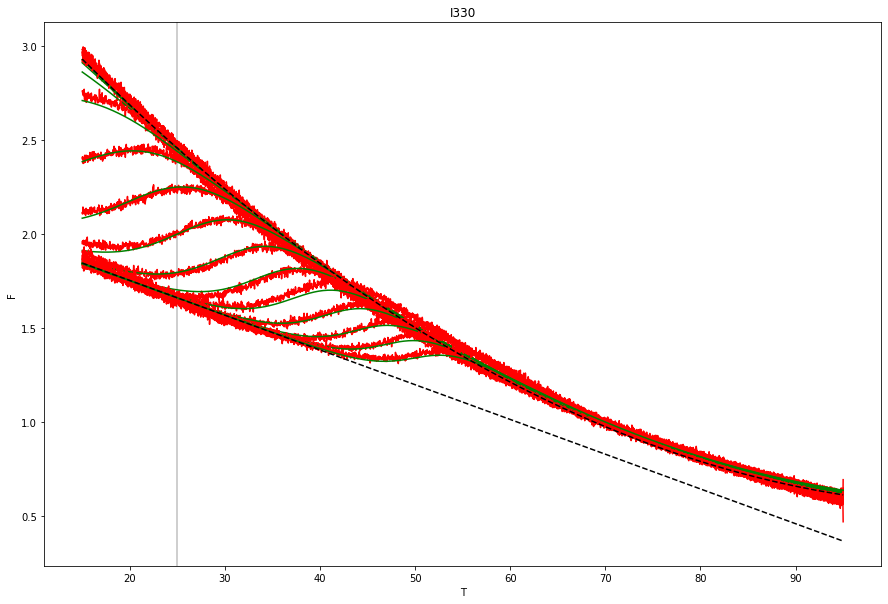

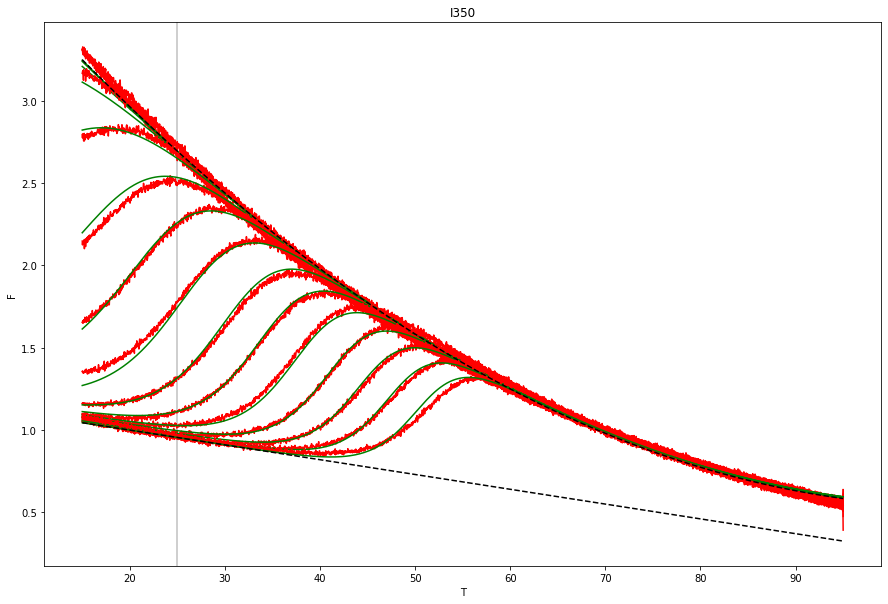

In [6]:
%matplotlib inline
denat_min = np.min(denat); denat_max = np.max(denat)
x_temp = np.linspace(temp_min,temp_max,500)
dT = x_temp - temp_target

# # Plot initial parameters
# p_data = [unfold2d_model.calc_sample(param_init, temp_target, x_temp, d['DENAT'], ['I330','I350']) 
#           for d in data2fit ]
# p = param_init.valuesdict()

# Plot fitted parameters
p_data = [unfold2d_model.calc_sample(fit.params, temp_target, x_temp, d['DENAT'], data2fit.get_curve_labels()) 
          for d in data2fit ]
p = fit.params.valuesdict()

for label in data2fit.get_curve_labels():
    plt.figure(figsize=(15, 10))
    ax = plt.subplot(111)
    ax.axvline(temp_target, color='silver')
    for di in range(len(data2fit)):
        plt.plot(data2fit[di]['T'], data2fit[di][label], linestyle='-', color='r')
        plt.plot(x_temp, p_data[di][label], linestyle='-', color='g')
    plt.plot(x_temp, p['a_F_'+label]+denat_min*p['b_F_D_'+label]+dT*p['b_F_T_'+label], '--', color='k')
    plt.plot(x_temp, p['a_U_'+label]+denat_max*p['b_U_D_'+label]+dT*p['b_U_T_'+label]+dT*dT*p['b_U_T2_'+label], 
             '--', color='k')
    plt.xlabel('T'); plt.ylabel('F'); plt.title(label); plt.show()

In [7]:
%matplotlib inline
# Parameters of model
param = fit.params
# param = param_init

p = param.valuesdict()
def folded_baseplane(p, D, T, label):
    return(p['a_F_'+label] + D*p['b_F_D_'+label] + T*p['b_F_T_'+label])    
def unfolded_baseplane(p, D, T, label):
    return(p['a_U_'+label] + D*p['b_U_D_'+label] + T*p['b_U_T_'+label] + T*T*p['b_U_T2_'+label])

# Model x-range (denaturant)
x_denat = np.linspace(np.min(denat), np.max(denat), 1000)

# Data y-range
Imin = np.nan; Imax = np.nan
for label in data2fit.get_curve_labels():
    Imin = np.nanmin(np.concatenate([np.array([Imin])]+[(d[label] if label in d.keys() else []) for d in data2fit]))
    Imax = np.nanmax(np.concatenate([np.array([Imax])]+[(d[label] if label in d.keys() else []) for d in data2fit]))
I10pct = (Imax-Imin)/10.0

# Plot model in denaturant dimension
def f(T):
    fig, ax = plt.subplots(figsize=(7, 5))
    # Predict curve at T
    p_data = unfold2d_model.calc_sample(param, temp_target, np.array([T]), x_denat, data2fit.get_curve_labels())
    for label in data2fit.get_curve_labels():
        curve = [(d[label][np.argmin(np.abs(d['T']-T))] if label in d.keys() else np.NaN) for d in data2fit]
        ax.plot(denat, curve, 'o-', label=label)
    for label in data2fit.get_curve_labels():
        plt.plot(x_denat, p_data[label], color='black')
    for label in data2fit.get_curve_labels():
        plt.plot(x_denat, folded_baseplane(p,x_denat,T-temp_target,label), ':', color='gray')
        plt.plot(x_denat, unfolded_baseplane(p,x_denat,T-temp_target,label), ':', color='gray')
        
    plt.ylim(Imin-I10pct,Imax+I10pct); plt.xlabel('Denaturant'); plt.ylabel('Intensity')
    legend = ax.legend(loc='upper left')
    plt.show()

i = interact(f, T=IntSlider(min=temp_min, max=temp_max, step=1, value=temp_target, continuous_update=False))

interactive(children=(IntSlider(value=25, continuous_update=False, description='T', max=95, min=15), Output())…

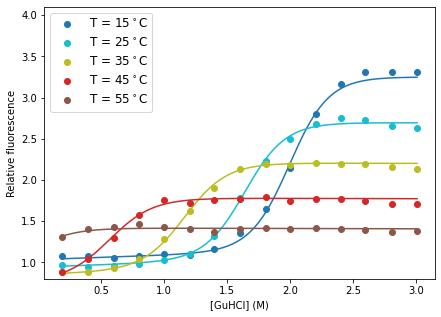

In [8]:
# Model x-range (denaturant)
x_denat = np.linspace(np.min(denat), np.max(denat), 1000)
label = 'I350'
col = {15: tab_col['tab:blue'], 25: tab_col['tab:cyan'], 35: tab_col['tab:olive'], 
       45: tab_col['tab:red'], 55: tab_col['tab:brown']}

fig, ax = plt.subplots(figsize=(7, 5))
for T in [15,25,35,45,55]:
    p_data = unfold2d_model.calc_sample(param, temp_target, np.array([T]), x_denat, data2fit.get_curve_labels())
    curve = [(d[label][np.argmin(np.abs(d['T']-T))] if label in d.keys() else np.NaN) for d in data2fit]
    ax.plot(denat, curve, 'o', color=col[T], label="T = %.0f$^\circ$C" % (T))
    plt.plot(x_denat, p_data[label], color=col[T])

plt.ylim(0.8,4.1); plt.xlabel('[GuHCl] (M)'); plt.ylabel('Relative fluorescence')
legend = ax.legend(loc='upper left', prop={'size': 12})
plt.show()

In [9]:
# Find the observed midpoints for all samples (from which dG(T0,0) is extrapolated)
Tmid = []; Dmid = [];
curve_labels = data2fit.get_curve_labels()
for d in data2fit:
    dT = d['T'][1] - d['T'][0]
    dG = calc_dG(fit.params, temp=d['T'], denat=d['DENAT'])
    for label in curve_labels:
        if not label in d.keys():
            continue
        # Normalize observed intensity to the model without baselines
        model = unfold2d_model.eval(fit.params, temp_target=temp_target, temp=d['T'], denat=d['DENAT'], label=label)
        new_label = label+"_norm"
        d[new_label] = d[label]/model/(1+np.exp(dG))
        # Split temperature axis in windows of 5 deg length to identify all midpoints
        wini = 0
        for win in np.array_split(np.arange(len(d['T'])), (d['T'][-1]-d['T'][0])//5):
            wini += 1
            ti = np.argmin(np.abs(d[new_label][win]-0.5))
            ti = win[ti]
#             print("Curve %s-%02d win %2d:  %.2f (T[%d]=%.1f)" % 
#                   (label, d['SAMPLE'], wini, np.abs(d[new_label][ti]-0.5), ti, d['T'][ti]))
            if np.abs(d[new_label][ti]-0.5) < dT/2:
                Tmid.append(d['T'][ti])
                Dmid.append(d['DENAT'])
#                 print("Midpoint: T=%.1f D=%.1f" % (Tmid[-1], Dmid[-1]))

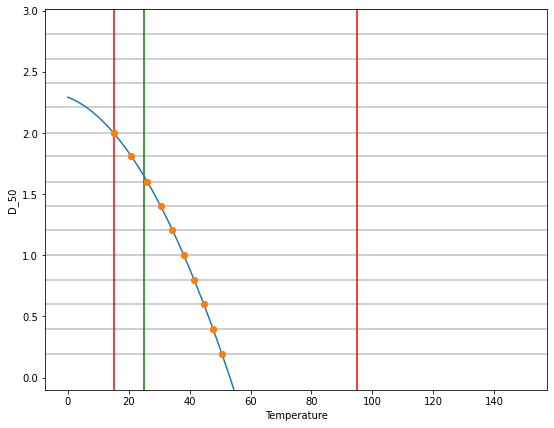

In [10]:
# When does the unfolding denaturant concentration, D_50, cross observed denaturant concentration?
# One advantage of 2D unfolding is that the denaturant unfolding condition is 'scanned' by constant 
# concentrations at many temperatures. This plot shows if this happens.
# At higher temperatures, D_50 is difficult to separate from baseline noise. Thus, use above plot 
# to determine the max temperature with reliable D_50.

p = fit.params.valuesdict()

x_temp = np.linspace(0, 150,500)
dT = x_temp - temp_target
D_50 = calc_dG(fit.params, x_temp)/(p['m0'] + p['m1']*dT + p['m2']*dT*dT)
fig, ax = plt.subplots(figsize=(9, 7))
[ax.axhline(d, color='silver') for d in denat]
ax.axvline(temp_min, color='r')
ax.axvline(temp_max, color='r')
ax.axvline(temp_target, color='g')
plt.plot(x_temp, D_50)
plt.plot(Tmid, Dmid, 'o')
plt.ylim(-0.1,np.max(denat))
plt.xlabel('Temperature'); plt.ylabel('D_50')
plt.show()


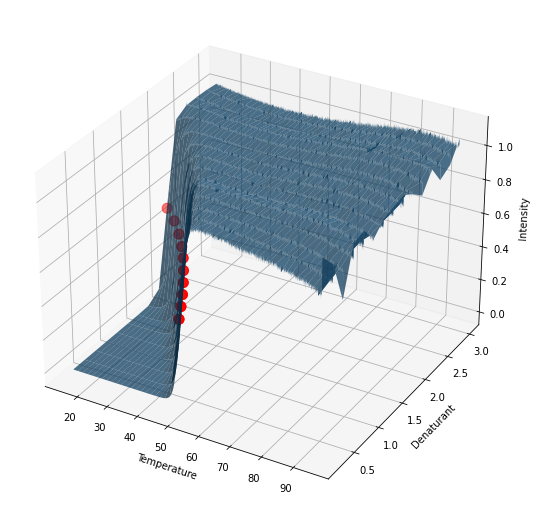

In [11]:
# 3D plot of model-normalized curve
from mpl_toolkits.mplot3d import Axes3D

# To enable rotating of the plot, use the notebook backend of matplotlib:
# %matplotlib notebook
# This may need a kernel restart and the above line run before matplotlib import. Sometimes, running the 
# line magic many times works... The interactive plots works best with the 'inline' backend

# A common temperature axis is needed for grid plotting
common_t = data2fit[0]['T']
t,d = np.meshgrid(common_t, denat)
obs = np.concatenate([d['I330_norm'] for d in data2fit])
# if this fails, perhaps T array.shape's are not identical in data2plot[:]
obs = obs.reshape(t.shape)

# 3D plot
fig = plt.figure(figsize=(9, 7))
ax = Axes3D(fig)
# Plot normalized data
surf = ax.plot_surface(t, d, obs, alpha=0.75)
# Plot observed midpoints
ax.scatter(Tmid, Dmid, 0.5, s=100, c="red") 
ax.set_xlabel('Temperature'); ax.set_ylabel('Denaturant'); ax.set_zlabel('Intensity')
plt.show()